In [2]:
import os

In [3]:
if not os.path.exists("data"):
  !wget -q https://www.dropbox.com/s/4f314zcoo0lvlzn/Brain%20Tumor%20Segmentation.zip?dl=0 --output-document tumor_dataset.zip
  !unzip -q tumor_dataset.zip
  !rm tumor_dataset.zip
  !pip install -q torch_snippets pytorch_model_summary
  !pip install -U segmentation-models-pytorch albumentations --user 
  !pip install segmentation_models_pytorch==0.2.1
  !pip install tensorflow==2.1.0
  !pip install keras==2.3.1

In [5]:
!pip install segmentation_models_pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
import albumentations as albu

In [9]:
from torchsummary import summary

In [6]:
import numpy as np
from skimage import color
import segmentation_models_pytorch as smp

In [10]:
data_dir = "data"
image_dir_name = "images"
mask_dir_name = "masks"
image_dir = os.path.join(data_dir,image_dir_name)
mask_dir = os.path.join(data_dir,mask_dir_name)

In [11]:
images = Glob(os.path.join(image_dir,"*.png"))
masks = Glob(os.path.join(mask_dir, "*.png"))

In [12]:
print(len(images), len(masks))

3064 3064

# Visualizations

In [13]:
img = read(images[0],1)

In [14]:
img.shape

(512, 512, 3)

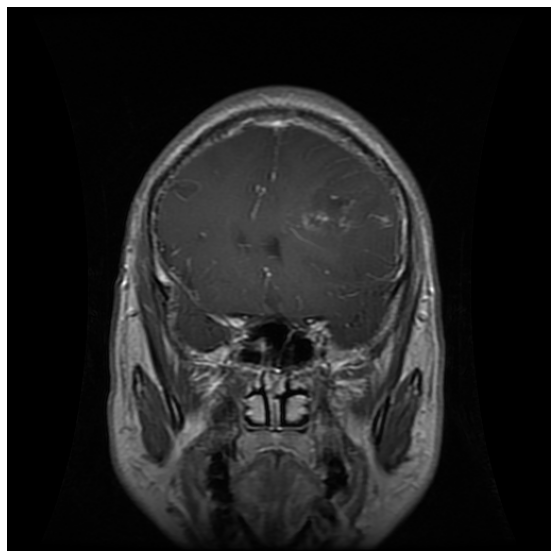

In [15]:
show(img)

In [16]:
msk = read(masks[0])


(512, 512)

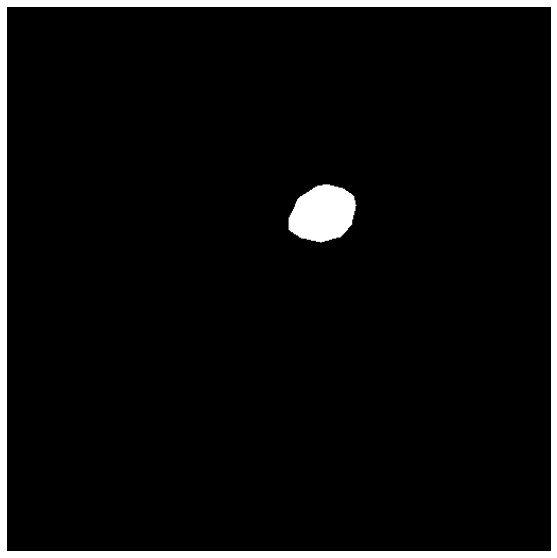

In [17]:
print(msk.shape)
show(msk)

In [18]:
msk = np.stack((msk,msk,msk),axis = 2)

In [19]:
overlayed_img = np.where(msk, (255,0,0), img) # Red overlay (255,0,0)

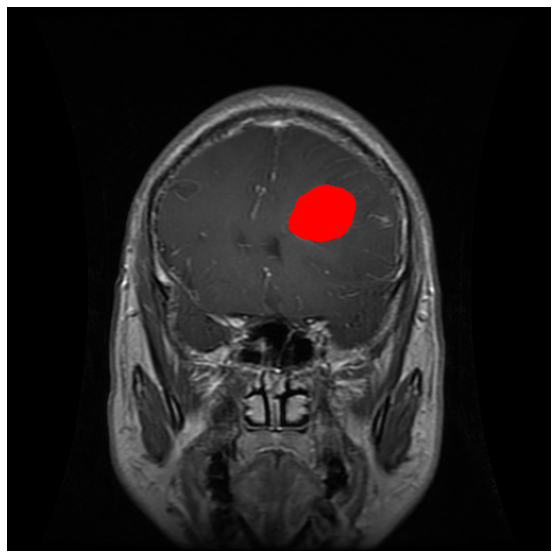

In [20]:
show(overlayed_img)

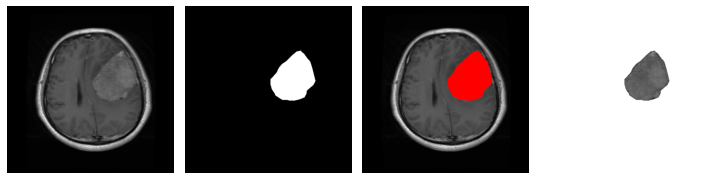

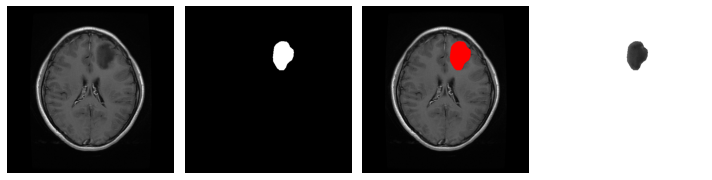

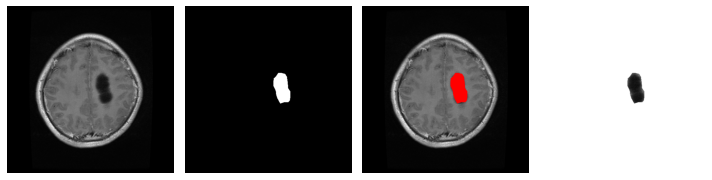

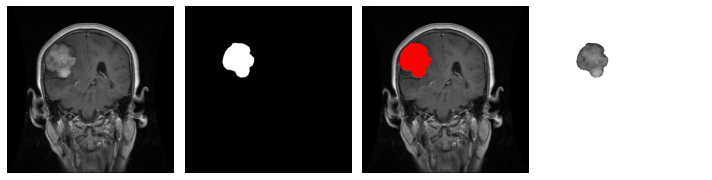

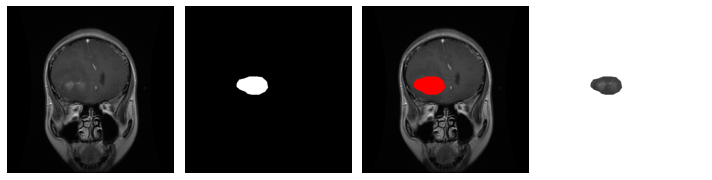

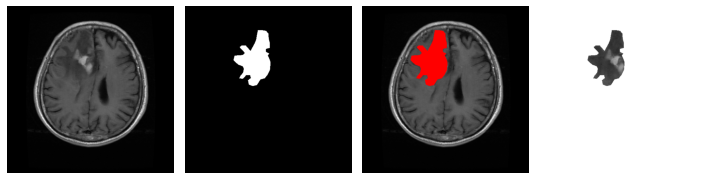

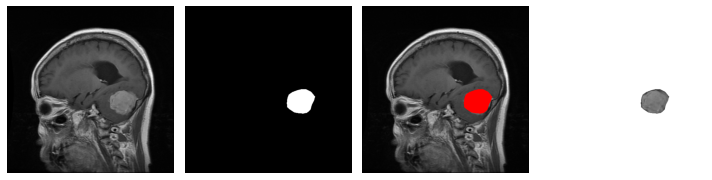

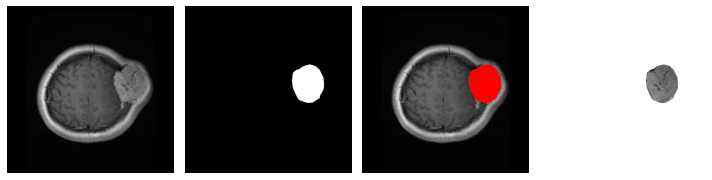

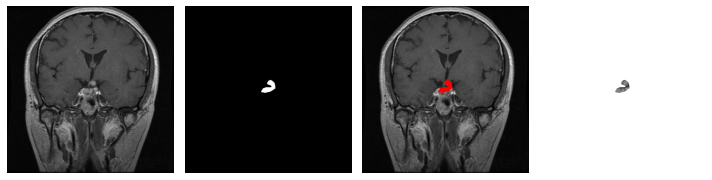

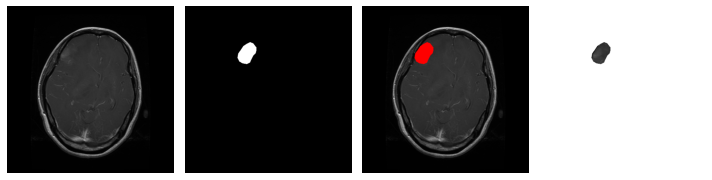

In [21]:

for i in range(10):
  index = np.random.choice(len(images))
  img = read(images[index],1)
  msk = read(masks[index])
  msk_stack = np.stack((msk,msk,msk),axis = 2)
  overlayed_img = np.where(msk_stack, (255,0,0), img) # Red overlay (255,0,0)

  rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
  rgba[:, :, 3] = msk
  subplots([img,msk, overlayed_img, rgba], figsize = (10,10))


# Training and Validation Split

In [22]:
combined = list(zip(images,masks))

In [23]:
trn_files, val_files = train_test_split(combined, random_state = 42,test_size=0.2)

# DataSet class

In [24]:
os.cpu_count()

2

In [25]:
# Image Transformation object
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [26]:
mask_tfms = transforms.ToTensor()

In [27]:
class BrainTumorDataset(Dataset):
  def __init__(self, items, preprocessing = None):
    self.items = items
    self.preprocessing = preprocessing

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
    item = self.items[ix]
    
    ## Getting image and mask path
    image_path = item[0]
    mask_path = item[1]
    
    ### Ingesting image and mask 
    image = read(image_path,1)
    mask = read(mask_path)

    ### resizing image and mask to 224,224. Will start with vgg16 backbone
    image = cv2.resize(image, (224,224))
    mask = cv2.resize(mask, (224,224))
    image = image/255.
    mask = mask/255.
    
    ## Adding depth dimension as image is greyscale
    mask = mask[...,np.newaxis]
    
    # apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image = image, mask = mask)
      image, mask = sample['image'], sample['mask']


    return image, mask

  # def collate_fn(self,batch):
  #   ims, masks = list(zip(*batch))
  #   #print(ims)
  #   ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)

  #   ###########  Changing mask to float
  #   #ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).float().to(device)
  #   ce_masks = torch.cat([mask_tfms(mask.copy()/255.)[None] for mask in masks]).float().to(device)
    
  #   return ims, ce_masks

  def choose(self):
    return self[randint(len(self))]







In [28]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [29]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [30]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = device
CLASSES = ['tumor']
preprocessing_fn  = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [31]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [32]:
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [33]:
train_ds = BrainTumorDataset(items=trn_files, preprocessing = get_preprocessing(preprocessing_fn))


In [34]:
temp_img, temp_msk = train_ds[0]

In [35]:
temp_img.shape

(3, 224, 224)

In [36]:
temp_msk.shape

(1, 224, 224)

In [37]:
valid_ds  =  BrainTumorDataset(items=val_files, preprocessing = get_preprocessing(preprocessing_fn))


In [38]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [39]:
loss = smp.losses.DiceLoss(mode = 'binary')

In [40]:
def IOU_Score(output,target,mode = 'binary',threshold = 0.5):
  tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode=mode, threshold=threshold)
  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
  return iou_score

In [41]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [42]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [48]:
# train model

n_epochs = 75

max_score = 0

log = Report(n_epochs)
for i in range(0, n_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    log.record( pos=(i+1),trn_dice_loss=train_logs['dice_loss'], trn_iou_score=train_logs['iou_score'], valid_dice_log = valid_logs['dice_loss'], valid_iou_score=valid_logs['iou_score'],end='\r')
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

Epoch: 0

train:   0%|          | 0/307 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid:   0%|          | 0/613 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid: 100%|██████████| 613/613 [00:20<00:00, 30.42it/s, dice_loss - 0.2255, iou_score - 0.6775]
EPOCH: 1.000  trn_dice_loss: 0.149  trn_iou_score: 0.750  valid_dice_log: 0.226  valid_iou_score: 0.677  (81.23s - 6011.21s remaining)

Model saved!

Epoch: 1

valid: 100%|██████████| 613/613 [00:18<00:00, 33.10it/s, dice_loss - 0.2242, iou_score - 0.6819]
EPOCH: 2.000  trn_dice_loss: 0.127  trn_iou_score: 0.782  valid_dice_log: 0.224  valid_iou_score: 0.682  (159.40s - 5818.10s remaining)

Model saved!

Epoch: 2

valid: 100%|██████████| 613/613 [00:19<00:00, 31.88it/s, dice_loss - 0.2206, iou_score - 0.6847]
EPOCH: 3.000  trn_dice_loss: 0.114  trn_iou_score: 0.803  valid_dice_log: 0.221  valid_iou_score: 0.685  (240.02s - 5760.54s remaining)

Model saved!

Epoch: 3

valid: 100%|██████████| 613/613 [00:19<00:00, 30.97it/s, dice_loss - 0.2089, iou_score - 0.6983]
EPOCH: 4.000  trn_dice_loss: 0.104  trn_iou_score: 0.818  valid_dice_log: 0.209  valid_iou_score: 0.698  (320.79s - 5694.06s remaining)

Model saved!

Epoch: 4

valid: 100%|██████████| 613/613 [00:20<00:00, 30.53it/s, dice_loss - 0.206, iou_score - 0.7034]
EPOCH: 5.000  trn_dice_loss: 0.092  trn_iou_score: 0.837  valid_dice_log: 0.206  valid_iou_score: 0.703  (400.81s - 5611.39s remaining)

Model saved!

Epoch: 5

valid: 100%|██████████| 613/613 [00:21<00:00, 28.81it/s, dice_loss - 0.1967, iou_score - 0.7111]
EPOCH: 6.000  trn_dice_loss: 0.086  trn_iou_score: 0.847  valid_dice_log: 0.197  valid_iou_score: 0.711  (483.41s - 5559.18s remaining)

Model saved!

Epoch: 6

valid: 100%|██████████| 613/613 [00:19<00:00, 32.06it/s, dice_loss - 0.1939, iou_score - 0.7159]
EPOCH: 7.000  trn_dice_loss: 0.082  trn_iou_score: 0.855  valid_dice_log: 0.194  valid_iou_score: 0.716  (562.64s - 5465.64s remaining)

Model saved!

Epoch: 7

valid: 100%|██████████| 613/613 [00:18<00:00, 33.04it/s, dice_loss - 0.1931, iou_score - 0.7173]
EPOCH: 8.000  trn_dice_loss: 0.076  trn_iou_score: 0.864  valid_dice_log: 0.193  valid_iou_score: 0.717  (641.69s - 5374.12s remaining)

Model saved!

Epoch: 8

valid: 100%|██████████| 613/613 [00:21<00:00, 28.70it/s, dice_loss - 0.2055, iou_score - 0.7024]
EPOCH: 9.000  trn_dice_loss: 0.075  trn_iou_score: 0.866  valid_dice_log: 0.206  valid_iou_score: 0.702  (723.38s - 5304.82s remaining)

Epoch: 9

valid: 100%|██████████| 613/613 [00:20<00:00, 29.99it/s, dice_loss - 0.1929, iou_score - 0.7152]
EPOCH: 10.000  trn_dice_loss: 0.075  trn_iou_score: 0.865  valid_dice_log: 0.193  valid_iou_score: 0.715  (803.14s - 5220.41s remaining)

Epoch: 10

valid: 100%|██████████| 613/613 [00:19<00:00, 31.36it/s, dice_loss - 0.2015, iou_score - 0.7089]
EPOCH: 11.000  trn_dice_loss: 0.071  trn_iou_score: 0.872  valid_dice_log: 0.201  valid_iou_score: 0.709  (882.53s - 5134.71s remaining)

Epoch: 11

valid: 100%|██████████| 613/613 [00:20<00:00, 30.32it/s, dice_loss - 0.1891, iou_score - 0.7225]
EPOCH: 12.000  trn_dice_loss: 0.065  trn_iou_score: 0.883  valid_dice_log: 0.189  valid_iou_score: 0.723  (963.68s - 5059.30s remaining)

Model saved!

Epoch: 12

valid: 100%|██████████| 613/613 [00:18<00:00, 32.83it/s, dice_loss - 0.194, iou_score - 0.7187]
EPOCH: 13.000  trn_dice_loss: 0.061  trn_iou_score: 0.890  valid_dice_log: 0.194  valid_iou_score: 0.719  (1043.01s - 4974.34s remaining)

Epoch: 13

valid: 100%|██████████| 613/613 [00:20<00:00, 30.34it/s, dice_loss - 0.1932, iou_score - 0.7198]
EPOCH: 14.000  trn_dice_loss: 0.057  trn_iou_score: 0.896  valid_dice_log: 0.193  valid_iou_score: 0.720  (1122.90s - 4892.63s remaining)

Epoch: 14

valid: 100%|██████████| 613/613 [00:21<00:00, 28.25it/s, dice_loss - 0.1925, iou_score - 0.7173]
EPOCH: 15.000  trn_dice_loss: 0.056  trn_iou_score: 0.898  valid_dice_log: 0.193  valid_iou_score: 0.717  (1205.30s - 4821.19s remaining)

Epoch: 15

valid: 100%|██████████| 613/613 [00:18<00:00, 32.60it/s, dice_loss - 0.1876, iou_score - 0.7267]
EPOCH: 16.000  trn_dice_loss: 0.054  trn_iou_score: 0.901  valid_dice_log: 0.188  valid_iou_score: 0.727  (1283.44s - 4732.69s remaining)

Model saved!

Epoch: 16

valid: 100%|██████████| 613/613 [00:19<00:00, 31.79it/s, dice_loss - 0.184, iou_score - 0.7279]
EPOCH: 17.000  trn_dice_loss: 0.052  trn_iou_score: 0.904  valid_dice_log: 0.184  valid_iou_score: 0.728  (1363.94s - 4653.44s remaining)

Model saved!

Epoch: 17

valid: 100%|██████████| 613/613 [00:20<00:00, 29.91it/s, dice_loss - 0.194, iou_score - 0.7151]
EPOCH: 18.000  trn_dice_loss: 0.052  trn_iou_score: 0.905  valid_dice_log: 0.194  valid_iou_score: 0.715  (1445.30s - 4576.77s remaining)

Epoch: 18

valid: 100%|██████████| 613/613 [00:20<00:00, 29.95it/s, dice_loss - 0.2039, iou_score - 0.7095]
EPOCH: 19.000  trn_dice_loss: 0.053  trn_iou_score: 0.903  valid_dice_log: 0.204  valid_iou_score: 0.709  (1525.21s - 4495.36s remaining)

Epoch: 19

valid: 100%|██████████| 613/613 [00:19<00:00, 31.39it/s, dice_loss - 0.1913, iou_score - 0.7228]
EPOCH: 20.000  trn_dice_loss: 0.050  trn_iou_score: 0.909  valid_dice_log: 0.191  valid_iou_score: 0.723  (1604.50s - 4412.39s remaining)

Epoch: 20

valid: 100%|██████████| 613/613 [00:20<00:00, 30.25it/s, dice_loss - 0.1929, iou_score - 0.7198]
EPOCH: 21.000  trn_dice_loss: 0.048  trn_iou_score: 0.912  valid_dice_log: 0.193  valid_iou_score: 0.720  (1685.95s - 4335.30s remaining)

Epoch: 21

valid: 100%|██████████| 613/613 [00:19<00:00, 31.33it/s, dice_loss - 0.1948, iou_score - 0.7186]
EPOCH: 22.000  trn_dice_loss: 0.045  trn_iou_score: 0.916  valid_dice_log: 0.195  valid_iou_score: 0.719  (1765.40s - 4253.00s remaining)

Epoch: 22

valid: 100%|██████████| 613/613 [00:20<00:00, 30.03it/s, dice_loss - 0.2012, iou_score - 0.7145]
EPOCH: 23.000  trn_dice_loss: 0.044  trn_iou_score: 0.918  valid_dice_log: 0.201  valid_iou_score: 0.714  (1845.48s - 4172.39s remaining)

Epoch: 23

valid: 100%|██████████| 613/613 [00:21<00:00, 28.27it/s, dice_loss - 0.1939, iou_score - 0.7205]
EPOCH: 24.000  trn_dice_loss: 0.044  trn_iou_score: 0.919  valid_dice_log: 0.194  valid_iou_score: 0.720  (1927.46s - 4095.85s remaining)

Epoch: 24

valid: 100%|██████████| 613/613 [00:19<00:00, 32.19it/s, dice_loss - 0.1955, iou_score - 0.7162]
EPOCH: 25.000  trn_dice_loss: 0.044  trn_iou_score: 0.919  valid_dice_log: 0.195  valid_iou_score: 0.716  (2005.98s - 4011.95s remaining)

Epoch: 25

valid: 100%|██████████| 613/613 [00:18<00:00, 32.39it/s, dice_loss - 0.1999, iou_score - 0.7142]
EPOCH: 26.000  trn_dice_loss: 0.043  trn_iou_score: 0.920  valid_dice_log: 0.200  valid_iou_score: 0.714  (2085.48s - 3930.33s remaining)

Decrease decoder learning rate to 1e-5!

Epoch: 26

valid: 100%|██████████| 613/613 [00:21<00:00, 27.93it/s, dice_loss - 0.1856, iou_score - 0.7283]
EPOCH: 27.000  trn_dice_loss: 0.040  trn_iou_score: 0.926  valid_dice_log: 0.186  valid_iou_score: 0.728  (2168.17s - 3854.52s remaining)

Model saved!

Epoch: 27

valid: 100%|██████████| 613/613 [00:20<00:00, 29.80it/s, dice_loss - 0.1886, iou_score - 0.7261]
EPOCH: 28.000  trn_dice_loss: 0.036  trn_iou_score: 0.933  valid_dice_log: 0.189  valid_iou_score: 0.726  (2248.75s - 3774.70s remaining)

Epoch: 28

valid: 100%|██████████| 613/613 [00:20<00:00, 29.32it/s, dice_loss - 0.1873, iou_score - 0.7276]
EPOCH: 29.000  trn_dice_loss: 0.034  trn_iou_score: 0.937  valid_dice_log: 0.187  valid_iou_score: 0.728  (2329.68s - 3695.36s remaining)

Epoch: 29

valid: 100%|██████████| 613/613 [00:20<00:00, 30.13it/s, dice_loss - 0.1876, iou_score - 0.7269]
EPOCH: 30.000  trn_dice_loss: 0.032  trn_iou_score: 0.941  valid_dice_log: 0.188  valid_iou_score: 0.727  (2410.87s - 3616.30s remaining)

Epoch: 30

valid: 100%|██████████| 613/613 [00:19<00:00, 32.06it/s, dice_loss - 0.1867, iou_score - 0.7276]
EPOCH: 31.000  trn_dice_loss: 0.031  trn_iou_score: 0.943  valid_dice_log: 0.187  valid_iou_score: 0.728  (2490.43s - 3534.81s remaining)

Epoch: 31

valid: 100%|██████████| 613/613 [00:21<00:00, 28.96it/s, dice_loss - 0.1863, iou_score - 0.7279]
EPOCH: 32.000  trn_dice_loss: 0.030  trn_iou_score: 0.945  valid_dice_log: 0.186  valid_iou_score: 0.728  (2571.61s - 3455.60s remaining)

Epoch: 32

valid: 100%|██████████| 613/613 [00:21<00:00, 28.47it/s, dice_loss - 0.1876, iou_score - 0.727]
EPOCH: 33.000  trn_dice_loss: 0.029  trn_iou_score: 0.948  valid_dice_log: 0.188  valid_iou_score: 0.727  (2653.71s - 3377.44s remaining)

Epoch: 33

valid: 100%|██████████| 613/613 [00:19<00:00, 31.92it/s, dice_loss - 0.1861, iou_score - 0.7284]
EPOCH: 34.000  trn_dice_loss: 0.028  trn_iou_score: 0.948  valid_dice_log: 0.186  valid_iou_score: 0.728  (2732.76s - 3295.38s remaining)

Model saved!

Epoch: 34

valid: 100%|██████████| 613/613 [00:19<00:00, 30.71it/s, dice_loss - 0.1871, iou_score - 0.7273]
EPOCH: 35.000  trn_dice_loss: 0.028  trn_iou_score: 0.949  valid_dice_log: 0.187  valid_iou_score: 0.727  (2814.63s - 3216.72s remaining)

Epoch: 35

valid: 100%|██████████| 613/613 [00:19<00:00, 30.99it/s, dice_loss - 0.1876, iou_score - 0.7264]
EPOCH: 36.000  trn_dice_loss: 0.027  trn_iou_score: 0.950  valid_dice_log: 0.188  valid_iou_score: 0.726  (2895.34s - 3136.62s remaining)

Epoch: 36

valid: 100%|██████████| 613/613 [00:20<00:00, 29.57it/s, dice_loss - 0.1881, iou_score - 0.7262]
EPOCH: 37.000  trn_dice_loss: 0.027  trn_iou_score: 0.950  valid_dice_log: 0.188  valid_iou_score: 0.726  (2975.94s - 3056.38s remaining)

Epoch: 37

valid: 100%|██████████| 613/613 [00:22<00:00, 27.13it/s, dice_loss - 0.1892, iou_score - 0.7247]
EPOCH: 38.000  trn_dice_loss: 0.027  trn_iou_score: 0.951  valid_dice_log: 0.189  valid_iou_score: 0.725  (3059.41s - 2978.89s remaining)

Epoch: 38

valid: 100%|██████████| 613/613 [00:19<00:00, 32.07it/s, dice_loss - 0.1881, iou_score - 0.7262]
EPOCH: 39.000  trn_dice_loss: 0.026  trn_iou_score: 0.952  valid_dice_log: 0.188  valid_iou_score: 0.726  (3138.11s - 2896.72s remaining)

Epoch: 39

valid: 100%|██████████| 613/613 [00:19<00:00, 31.70it/s, dice_loss - 0.187, iou_score - 0.7272]
EPOCH: 40.000  trn_dice_loss: 0.027  trn_iou_score: 0.952  valid_dice_log: 0.187  valid_iou_score: 0.727  (3218.16s - 2815.89s remaining)

Epoch: 40

valid: 100%|██████████| 613/613 [00:22<00:00, 27.38it/s, dice_loss - 0.1878, iou_score - 0.7262]
EPOCH: 41.000  trn_dice_loss: 0.026  trn_iou_score: 0.952  valid_dice_log: 0.188  valid_iou_score: 0.726  (3300.64s - 2737.12s remaining)

Epoch: 41

valid: 100%|██████████| 613/613 [00:20<00:00, 29.25it/s, dice_loss - 0.1861, iou_score - 0.7273]
EPOCH: 42.000  trn_dice_loss: 0.026  trn_iou_score: 0.952  valid_dice_log: 0.186  valid_iou_score: 0.727  (3381.33s - 2656.76s remaining)

Epoch: 42

valid: 100%|██████████| 613/613 [00:20<00:00, 29.34it/s, dice_loss - 0.1868, iou_score - 0.7272]
EPOCH: 43.000  trn_dice_loss: 0.026  trn_iou_score: 0.952  valid_dice_log: 0.187  valid_iou_score: 0.727  (3462.53s - 2576.77s remaining)

Epoch: 43

valid: 100%|██████████| 613/613 [00:19<00:00, 31.62it/s, dice_loss - 0.189, iou_score - 0.7249]
EPOCH: 44.000  trn_dice_loss: 0.026  trn_iou_score: 0.953  valid_dice_log: 0.189  valid_iou_score: 0.725  (3542.31s - 2495.72s remaining)

Epoch: 44

valid: 100%|██████████| 613/613 [00:22<00:00, 27.26it/s, dice_loss - 0.1882, iou_score - 0.7258]
EPOCH: 45.000  trn_dice_loss: 0.025  trn_iou_score: 0.953  valid_dice_log: 0.188  valid_iou_score: 0.726  (3625.30s - 2416.87s remaining)

Epoch: 45

valid: 100%|██████████| 613/613 [00:21<00:00, 28.48it/s, dice_loss - 0.1893, iou_score - 0.7245]
EPOCH: 46.000  trn_dice_loss: 0.026  trn_iou_score: 0.953  valid_dice_log: 0.189  valid_iou_score: 0.725  (3706.75s - 2336.86s remaining)

Epoch: 46

valid: 100%|██████████| 613/613 [00:21<00:00, 28.74it/s, dice_loss - 0.1878, iou_score - 0.7259]
EPOCH: 47.000  trn_dice_loss: 0.025  trn_iou_score: 0.954  valid_dice_log: 0.188  valid_iou_score: 0.726  (3788.61s - 2257.04s remaining)

Epoch: 47

valid: 100%|██████████| 613/613 [00:20<00:00, 29.61it/s, dice_loss - 0.1886, iou_score - 0.7256]
EPOCH: 48.000  trn_dice_loss: 0.025  trn_iou_score: 0.954  valid_dice_log: 0.189  valid_iou_score: 0.726  (3871.25s - 2177.58s remaining)

Epoch: 48

valid: 100%|██████████| 613/613 [00:19<00:00, 31.24it/s, dice_loss - 0.1878, iou_score - 0.7258]
EPOCH: 49.000  trn_dice_loss: 0.025  trn_iou_score: 0.955  valid_dice_log: 0.188  valid_iou_score: 0.726  (3952.31s - 2097.15s remaining)

Epoch: 49

valid: 100%|██████████| 613/613 [00:21<00:00, 28.01it/s, dice_loss - 0.1924, iou_score - 0.7219]
EPOCH: 50.000  trn_dice_loss: 0.025  trn_iou_score: 0.955  valid_dice_log: 0.192  valid_iou_score: 0.722  (4034.65s - 2017.33s remaining)

Epoch: 50

valid: 100%|██████████| 613/613 [00:21<00:00, 28.51it/s, dice_loss - 0.191, iou_score - 0.7228]
EPOCH: 51.000  trn_dice_loss: 0.025  trn_iou_score: 0.955  valid_dice_log: 0.191  valid_iou_score: 0.723  (4116.35s - 1937.11s remaining)

Epoch: 51

valid: 100%|██████████| 613/613 [00:19<00:00, 30.98it/s, dice_loss - 0.1885, iou_score - 0.7247]
EPOCH: 52.000  trn_dice_loss: 0.025  trn_iou_score: 0.955  valid_dice_log: 0.189  valid_iou_score: 0.725  (4196.17s - 1856.00s remaining)

Epoch: 52

valid: 100%|██████████| 613/613 [00:20<00:00, 29.72it/s, dice_loss - 0.187, iou_score - 0.7262]
EPOCH: 53.000  trn_dice_loss: 0.024  trn_iou_score: 0.956  valid_dice_log: 0.187  valid_iou_score: 0.726  (4278.58s - 1776.01s remaining)

Epoch: 53

valid: 100%|██████████| 613/613 [00:20<00:00, 30.33it/s, dice_loss - 0.1899, iou_score - 0.7235]
EPOCH: 54.000  trn_dice_loss: 0.024  trn_iou_score: 0.957  valid_dice_log: 0.190  valid_iou_score: 0.724  (4359.02s - 1695.17s remaining)

Epoch: 54

valid: 100%|██████████| 613/613 [00:21<00:00, 29.02it/s, dice_loss - 0.1888, iou_score - 0.7245]
EPOCH: 55.000  trn_dice_loss: 0.024  trn_iou_score: 0.956  valid_dice_log: 0.189  valid_iou_score: 0.724  (4439.93s - 1614.52s remaining)

Epoch: 55

valid: 100%|██████████| 613/613 [00:19<00:00, 30.96it/s, dice_loss - 0.1903, iou_score - 0.7236]
EPOCH: 56.000  trn_dice_loss: 0.024  trn_iou_score: 0.957  valid_dice_log: 0.190  valid_iou_score: 0.724  (4520.02s - 1533.58s remaining)

Epoch: 56

valid: 100%|██████████| 613/613 [00:20<00:00, 29.24it/s, dice_loss - 0.1901, iou_score - 0.7237]
EPOCH: 57.000  trn_dice_loss: 0.024  trn_iou_score: 0.956  valid_dice_log: 0.190  valid_iou_score: 0.724  (4602.62s - 1453.46s remaining)

Epoch: 57

valid: 100%|██████████| 613/613 [00:20<00:00, 30.40it/s, dice_loss - 0.1891, iou_score - 0.725]
EPOCH: 58.000  trn_dice_loss: 0.023  trn_iou_score: 0.957  valid_dice_log: 0.189  valid_iou_score: 0.725  (4683.08s - 1372.63s remaining)

Epoch: 58

valid: 100%|██████████| 613/613 [00:21<00:00, 29.12it/s, dice_loss - 0.1889, iou_score - 0.7246]
EPOCH: 59.000  trn_dice_loss: 0.024  trn_iou_score: 0.956  valid_dice_log: 0.189  valid_iou_score: 0.725  (4764.28s - 1292.01s remaining)

Epoch: 59

valid: 100%|██████████| 613/613 [00:21<00:00, 28.30it/s, dice_loss - 0.1895, iou_score - 0.7242]
EPOCH: 60.000  trn_dice_loss: 0.023  trn_iou_score: 0.957  valid_dice_log: 0.189  valid_iou_score: 0.724  (4846.26s - 1211.57s remaining)

Epoch: 60

valid: 100%|██████████| 613/613 [00:20<00:00, 29.88it/s, dice_loss - 0.1917, iou_score - 0.7218]
EPOCH: 61.000  trn_dice_loss: 0.023  trn_iou_score: 0.958  valid_dice_log: 0.192  valid_iou_score: 0.722  (4927.29s - 1130.85s remaining)

Epoch: 61

valid: 100%|██████████| 613/613 [00:19<00:00, 31.19it/s, dice_loss - 0.1898, iou_score - 0.7241]
EPOCH: 62.000  trn_dice_loss: 0.023  trn_iou_score: 0.958  valid_dice_log: 0.190  valid_iou_score: 0.724  (5007.53s - 1049.97s remaining)

Epoch: 62

valid: 100%|██████████| 613/613 [00:21<00:00, 29.15it/s, dice_loss - 0.1911, iou_score - 0.7229]
EPOCH: 63.000  trn_dice_loss: 0.023  trn_iou_score: 0.958  valid_dice_log: 0.191  valid_iou_score: 0.723  (5088.73s - 969.28s remaining)

Epoch: 63

valid: 100%|██████████| 613/613 [00:22<00:00, 27.13it/s, dice_loss - 0.19, iou_score - 0.7237]
EPOCH: 64.000  trn_dice_loss: 0.023  trn_iou_score: 0.958  valid_dice_log: 0.190  valid_iou_score: 0.724  (5172.15s - 888.96s remaining)

Epoch: 64

valid: 100%|██████████| 613/613 [00:19<00:00, 31.28it/s, dice_loss - 0.189, iou_score - 0.7243]
EPOCH: 65.000  trn_dice_loss: 0.023  trn_iou_score: 0.958  valid_dice_log: 0.189  valid_iou_score: 0.724  (5252.04s - 808.01s remaining)

Epoch: 65

valid: 100%|██████████| 613/613 [00:19<00:00, 31.44it/s, dice_loss - 0.1912, iou_score - 0.7224]
EPOCH: 66.000  trn_dice_loss: 0.023  trn_iou_score: 0.959  valid_dice_log: 0.191  valid_iou_score: 0.722  (5332.46s - 727.15s remaining)

Epoch: 66

valid: 100%|██████████| 613/613 [00:21<00:00, 29.11it/s, dice_loss - 0.1891, iou_score - 0.724]
EPOCH: 67.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.189  valid_iou_score: 0.724  (5413.93s - 646.44s remaining)

Epoch: 67

valid: 100%|██████████| 613/613 [00:22<00:00, 27.13it/s, dice_loss - 0.1913, iou_score - 0.7222]
EPOCH: 68.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.191  valid_iou_score: 0.722  (5497.50s - 565.92s remaining)

Epoch: 68

valid: 100%|██████████| 613/613 [00:19<00:00, 30.86it/s, dice_loss - 0.1907, iou_score - 0.7229]
EPOCH: 69.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.191  valid_iou_score: 0.723  (5577.31s - 484.98s remaining)

Epoch: 69

valid: 100%|██████████| 613/613 [00:19<00:00, 31.56it/s, dice_loss - 0.1912, iou_score - 0.7223]
EPOCH: 70.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.191  valid_iou_score: 0.722  (5657.60s - 404.11s remaining)

Epoch: 70

valid: 100%|██████████| 613/613 [00:21<00:00, 28.99it/s, dice_loss - 0.1915, iou_score - 0.722]
EPOCH: 71.000  trn_dice_loss: 0.022  trn_iou_score: 0.960  valid_dice_log: 0.192  valid_iou_score: 0.722  (5739.23s - 323.34s remaining)

Epoch: 71

valid: 100%|██████████| 613/613 [00:22<00:00, 27.02it/s, dice_loss - 0.1888, iou_score - 0.7246]
EPOCH: 72.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.189  valid_iou_score: 0.725  (5822.68s - 242.61s remaining)

Epoch: 72

valid: 100%|██████████| 613/613 [00:20<00:00, 30.39it/s, dice_loss - 0.1894, iou_score - 0.7236]
EPOCH: 73.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.189  valid_iou_score: 0.724  (5902.88s - 161.72s remaining)

Epoch: 73

valid: 100%|██████████| 613/613 [00:20<00:00, 30.00it/s, dice_loss - 0.1905, iou_score - 0.7226]
EPOCH: 74.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.191  valid_iou_score: 0.723  (5983.89s - 80.86s remaining)

Epoch: 74

valid: 100%|██████████| 613/613 [00:21<00:00, 28.38it/s, dice_loss - 0.1904, iou_score - 0.7226]
EPOCH: 75.000  trn_dice_loss: 0.022  trn_iou_score: 0.960  valid_dice_log: 0.190  valid_iou_score: 0.723  (6065.80s - 0.00s remaining)

100%|██████████| 176/176 [00:00<00:00, 21725.75it/s]


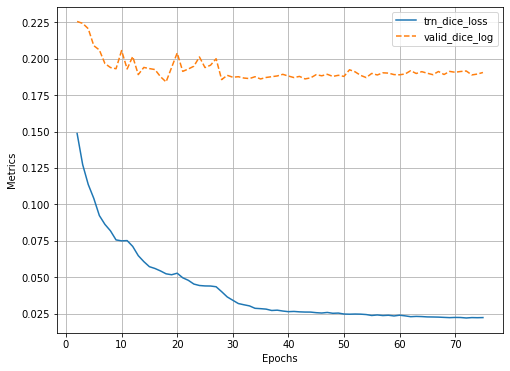

In [51]:
log.plot_epochs(['trn_dice_loss','valid_dice_log'])

100%|██████████| 176/176 [00:00<00:00, 30990.66it/s]


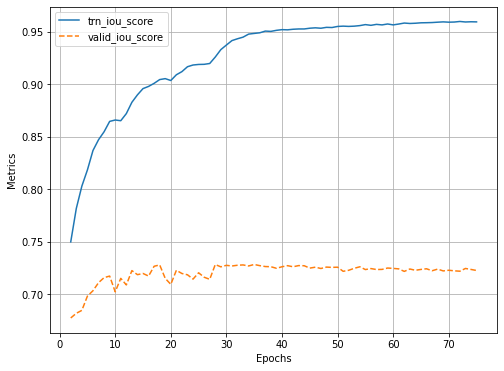

In [52]:
log.plot_epochs(['trn_iou_score','valid_iou_score'])

In [53]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [54]:
img, mask = valid_ds.choose()

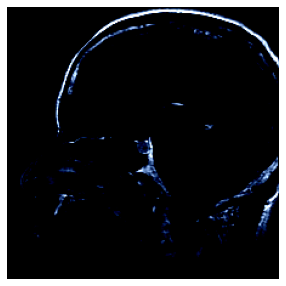

In [55]:
show(img)

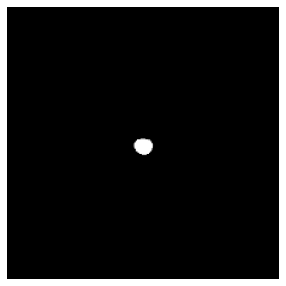

In [56]:
show(mask.reshape((224,224)))

In [57]:
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)

In [58]:
pr_mask = best_model.predict(x_tensor)

In [59]:
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

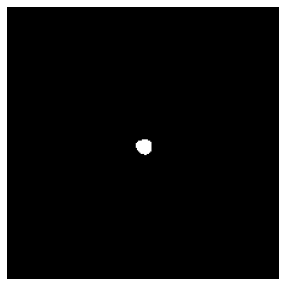

In [60]:
show(pr_mask)

# Inferencing on new image

In [61]:
index = np.random.choice(len(combined))

In [62]:
img_path, mask_path = combined[index]

In [63]:
img_inference = read(img_path,1)
mask = read(mask_path)

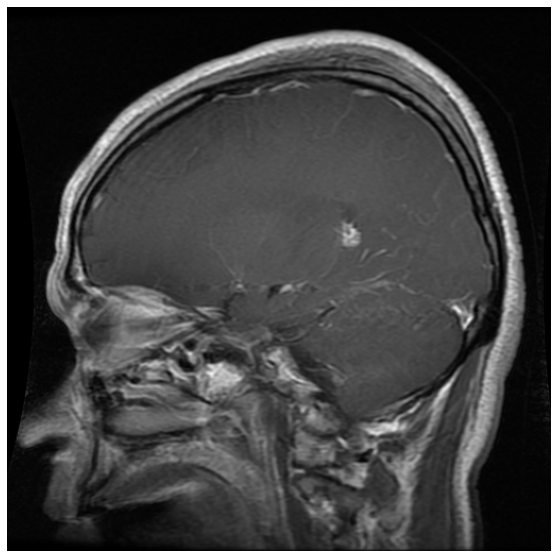

In [64]:
show(img_inference)

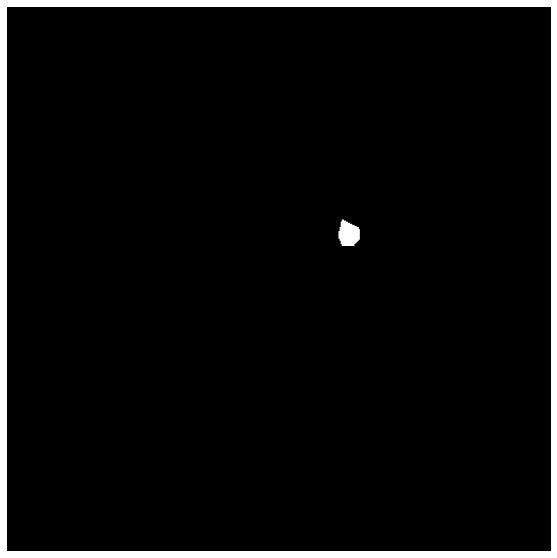

In [65]:
show(mask)

In [66]:
prepro_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [67]:
img_inference = cv2.resize(img_inference, (224,224))

In [68]:
img = img_inference.copy()

In [69]:
img = img/255.

In [70]:
img = np.array(img)

In [71]:
img = prepro_fn(img)

In [72]:
img = to_tensor(img)

In [73]:
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)

In [74]:
pr_mask = best_model.predict(x_tensor)

In [75]:
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

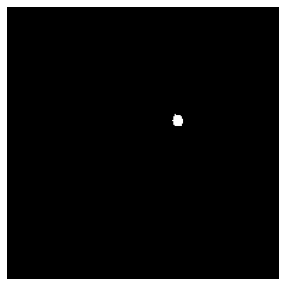

In [76]:
show(pr_mask)

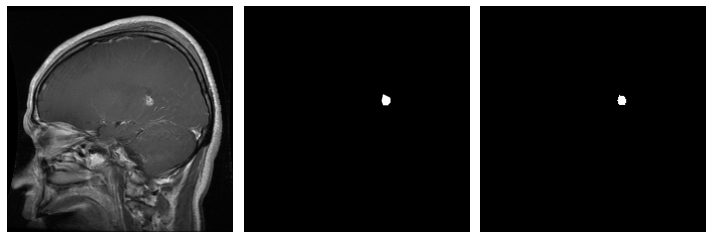

In [77]:
subplots([img_inference, mask, pr_mask],figsize=(10,10))

# Inference on multiple images

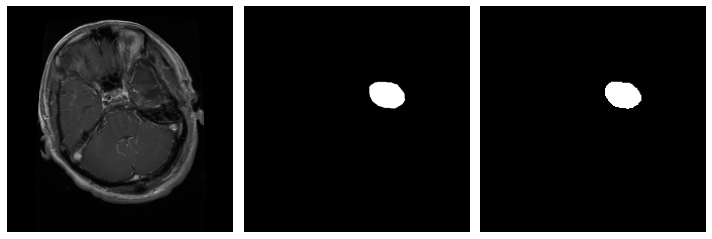

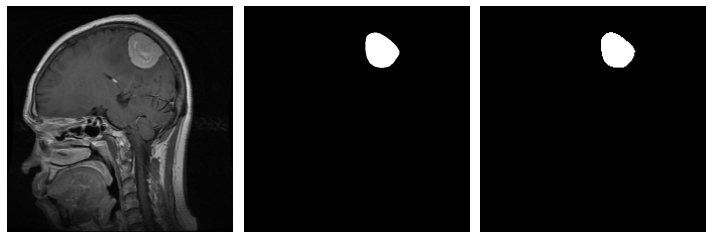

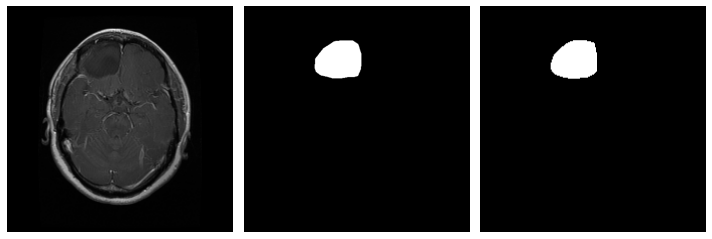

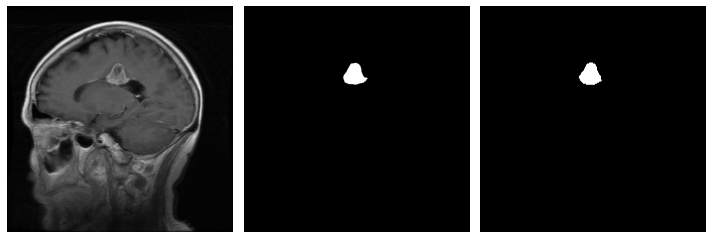

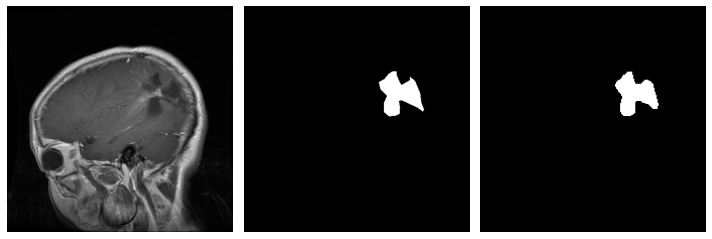

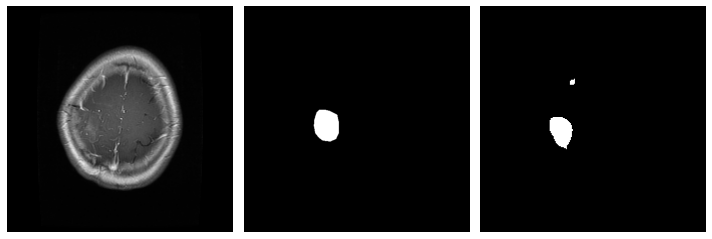

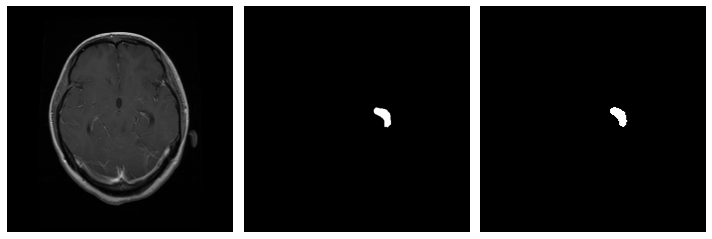

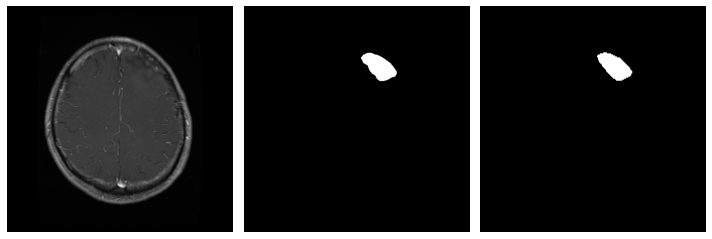

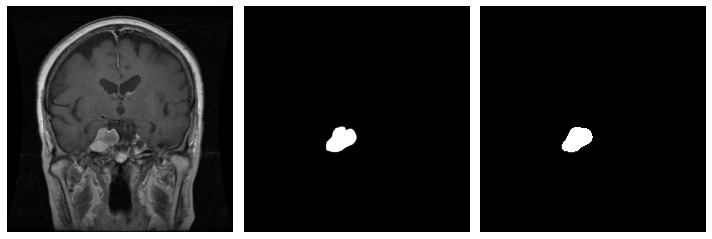

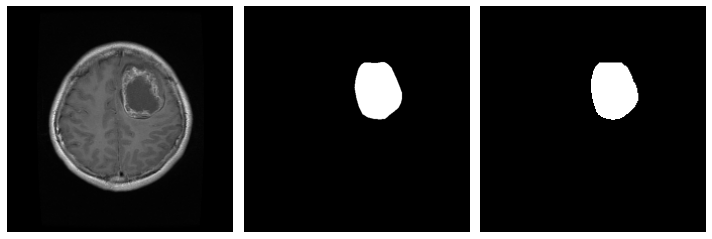

In [78]:
for i in range(10):
  index = np.random.choice(len(combined))
  img_path, mask_path = combined[index]
  img_inference = read(img_path,1)
  mask = read(mask_path)
  prepro_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
  img_inference = cv2.resize(img_inference, (224,224))
  img = img_inference.copy()
  img = img/255.
  img = np.array(img)
  img = prepro_fn(img)
  img = to_tensor(img)
  x_tensor = torch.from_numpy(img).to("cpu").unsqueeze(0) ### cpu inferecning
  pr_mask = best_model.to("cpu").predict(x_tensor)  ## cpu inferencing
  pr_mask = (pr_mask.squeeze().cpu().numpy().round())
  subplots([img_inference, mask, pr_mask],figsize=(10,10))